1. Implement Out-Of-Bag (OOB) error estimation in RandomForestRegressor
2. Implement feature importance evaluation using Mean Decrease in Impurity and Permutation Feature Importance
3. Tune tree depth using OOB score (visualize as a plot)

In [122]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from typing import Literal, Optional
from collections import defaultdict
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

class RandomForestRegressor():
    def __init__(self, n, random_state=None, 
                 criterion: Literal['absolute_error', 'squared_error']='squared_error',
                 oob_scoring: Literal['absolute_error', 'squared_error']='squared_error'):
        self.n = n    
        self.trees = []
        self.rng = np.random.default_rng(seed=random_state)
        self.criterion = criterion
        self.oob_score_ = None        
        self.oob_metric = None                
        if oob_scoring == 'squared_error':
            self.oob_metric = mean_squared_error
        if oob_scoring == 'absolute_error':
            self.oob_metric = mean_absolute_error        

    def fit(self, X, y):            
        self.oob_predictions_ = defaultdict(list)
        self.oob_true_labels_ = {}
        num_samples = X.shape[0]            
        num_features = X.shape[1]
        max_features = num_features // 3    
        self.feature_importances_ = np.zeros(num_features)    

        for i in range(self.n):                 
            indices = np.arange(num_samples)       
            bootstrap_indices = self.rng.choice(indices, size=num_samples, replace=True)                                                
            oob_mask = np.ones(num_samples, dtype=bool)
            oob_mask[bootstrap_indices] = False
            oob_indices = indices[oob_mask]
            
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]                    
            
            
            tree = DecisionTreeRegressor(
                criterion=self.criterion,
                max_depth=None,
                max_features=max_features,            
                min_samples_split=2,        
                random_state=i,                             
            )            
            tree.fit(X_bootstrap, y_bootstrap)                                                

            self.feature_importances_ += tree.feature_importances_                        

            if len(oob_indices) > 0:
                X_oob = X[oob_indices]                
                oob_preds = tree.predict(X_oob)

                for j, idx in enumerate(oob_indices):
                    self.oob_predictions_[idx].append(oob_preds[j])
                    self.oob_true_labels_[idx] = y[idx]                                

            self.trees.append(tree)
        
        self.feature_importances_ /= self.n
        self.oob_score_ = self._score_oob()
        return self 

    def _score_oob(self):        
        y_true = []
        y_pred = []
        
        for idx, predictions in self.oob_predictions_.items():            
            y_true.append(self.oob_true_labels_[idx])
            y_pred.append(np.mean(predictions))            

        return self.oob_metric(y_true, y_pred)
        

    def predict(self,X):
        Y = []
        for tree in self.trees:                        
            Y.append(tree.predict(X))
        Y = np.array(Y)                       
        # if self.criterion == 'absolute_error':
        #     return np.median(Y, axis=0).flatten()
        # if self.criterion == 'squared_error':
        #     return np.mean(Y, axis=0).flatten()        
        Y = np.mean(Y, axis=0).flatten()
        return Y       

In [101]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
r2_on_train = []
r2_on_test = []
mae_on_test = []
mae_on_oob = []
model_counts = np.concatenate((
    np.linspace(1, 100, 10, dtype=int), np.linspace(101, 1000, 10, dtype=int), [1500, 2000, 2500, 3000]
))

for n in model_counts:
    print('models count', n)
    rfr = RandomForestRegressor(n=n, random_state=42, criterion='absolute_error', oob_scoring='absolute_error')
    rfr.fit(X_train, y_train)    
    y_pred = rfr.predict(X_test)
    y_pred_train = rfr.predict(X_train)
    

    r2_on_train.append(round(r2_score(y_train, y_pred_train), 2))
    r2_on_test.append(round(r2_score(y_test, y_pred), 2))
    mae_on_test.append(round(mean_absolute_error(y_test, y_pred), 2))
    mae_on_oob.append(round(rfr.oob_score_, 2))

models count 1
models count 12
models count 23
models count 34
models count 45
models count 56
models count 67
models count 78
models count 89
models count 100
models count 101
models count 200
models count 300
models count 400
models count 500
models count 600
models count 700
models count 800
models count 900
models count 1000
models count 1500
models count 2000
models count 2500
models count 3000


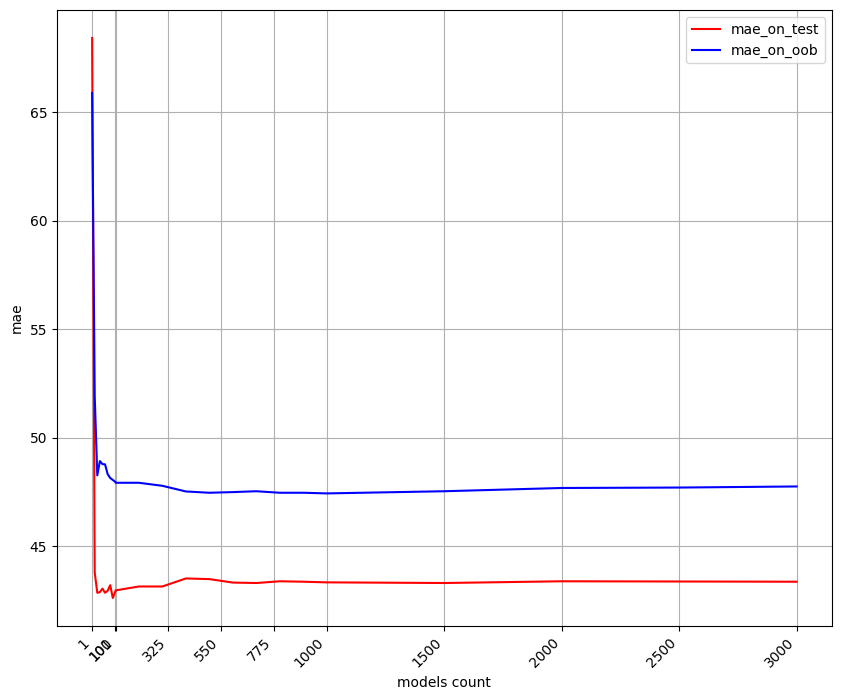

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(model_counts, mae_on_test, label='mae_on_test', color='red')
plt.plot(model_counts, mae_on_oob, label='mae_on_oob', color='blue')
plt.xlabel('models count')
plt.ylabel('mae')
plt.xticks(
    np.concatenate((
        np.linspace(1, 100, 2, dtype=int), np.linspace(101, 1000, 5, dtype=int), [1500, 2000, 2500, 3000]
    )),
    rotation=45,
    ha='right'
)
plt.legend()
plt.grid(True)
plt.show()

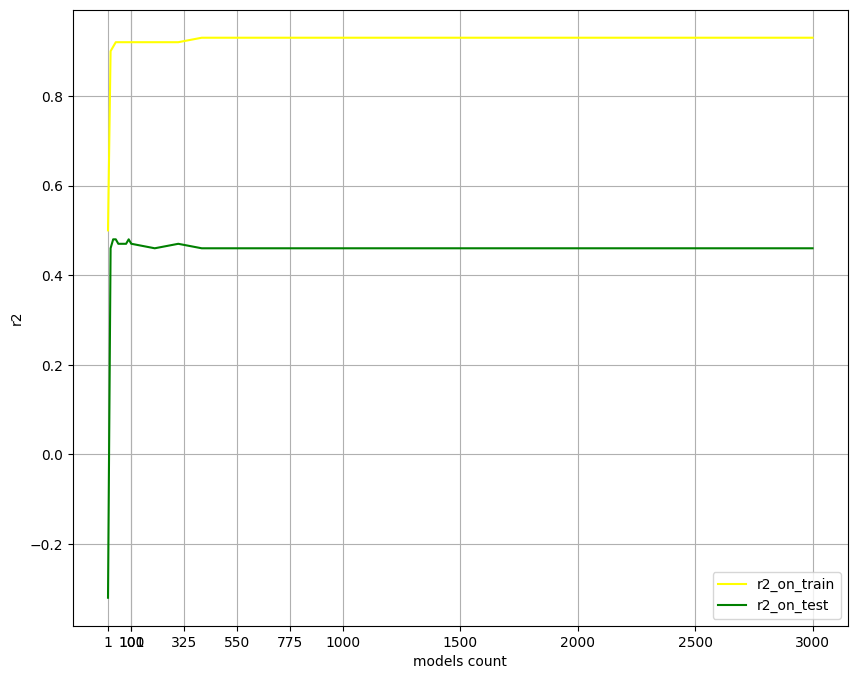

In [105]:
plt.figure(figsize=(10, 8))
plt.plot(model_counts, r2_on_train, label='r2_on_train', color='yellow')
plt.plot(model_counts, r2_on_test, label='r2_on_test', color='green')
plt.xticks(
    np.concatenate((
        np.linspace(1, 100, 2, dtype=int), np.linspace(101, 1000, 5, dtype=int), [1500, 2000, 2500, 3000]
    )),    
)
plt.xlabel('models count')
plt.ylabel('r2')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
best_n = model_counts[np.argmin(mae_on_test)]
print('best n', best_n)

best n 89


The ensemble appears to overfit based on the R2 gap between training and test sets, which is expected due to the use of fully grown decision trees. However, this overfitting is mitigated by the ensemble effect — specifically, averaging over many diverse trees reduces variance and improves generalization.

In [123]:
rfr = RandomForestRegressor(best_n, 42, criterion='absolute_error', oob_scoring='absolute_error')
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print('mae on test', mean_absolute_error(y_test, y_pred))
print('r2 on test', r2_score(y_test, y_pred))
print('r2 on train', r2_score(y_train, rfr.predict(X_train)))
print('oob score', rfr.oob_score_)

mae on test 42.61002398687034
r2 on test 0.47619212034002145
r2 on train 0.9227272396907045
oob score 48.054532993266626


In [125]:
print('feature importances')
print(rfr.feature_importances_)

feature importances
[0.07232472 0.01576378 0.20029202 0.12178082 0.07608357 0.08411897
 0.09233327 0.06086411 0.1794788  0.09695993]


### Implementing permutation feature imptortances and compare with sklearn

In [153]:
def pfi(forest, X, y, scoring: Literal['squared_error', 'absolute_error']='squared_error', n_repeats=5, random_state = 42):
    scoring_func = None
    if scoring == 'squared_error':
        scoring_func = mean_squared_error
    if scoring == 'absolute_error':
        scoring_func = mean_absolute_error        


    base_pred = forest.predict(X)
    base_score = scoring_func(y, base_pred)    
    num_features = X.shape[1]
    permutation_importances = np.zeros(num_features)
    
    rng = np.random.default_rng(random_state)    

    for feature_idx in range(num_features):
        feature_scores = []
        for _ in range(n_repeats):
            X_shuffled = X.copy()
            shuffled_column = rng.permutation(X_shuffled[:, feature_idx])
            X_shuffled[:, feature_idx] = shuffled_column

            shuffled_pred = forest.predict(X_shuffled)            
            shuffled_score = scoring_func(y, shuffled_pred)            
            # the greater the increase in error, the more important the feature is
            feature_scores.append(shuffled_score - base_score)
        
        permutation_importances[feature_idx] = np.mean(feature_scores)
    return permutation_importances

In [154]:
print('feature_importances', pfi(rfr, X_test, y_test, 'absolute_error', 5, 42))

feature_importances [ 0.88640323  0.22997096  8.22317889  1.46431006  0.03287464 -0.07203636
  1.24671127  1.46655725  7.37848756  0.50682995]


In [158]:
from sklearn.inspection import permutation_importance

permutation_importance(rfr, X_test, y_test, scoring='neg_mean_absolute_error', n_repeats=5, random_state=42)['importances_mean']

array([ 0.88450953,  0.3580861 ,  8.15205151,  1.27786896, -0.04552455,
       -0.29185709,  1.24241889,  0.56818584,  7.02969322,  0.33286201])

My implementation is ok